.. index:: Grid construction

# Examples of grid construction
Besides the already discussed construction of Cartesian grid and using
dictionaries [from general concepts](dune-corepy_nb.ipynb) it is also possible
to read grid files using either the `DGF` or `gmsh` format (or other
formats available through the `meshio` package).


In [1]:
import numpy
from matplotlib import pyplot
from dune.alugrid import aluSimplexGrid as leafGridView
from dune.grid import OutputType, reader
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from ufl import TestFunction, TrialFunction, SpatialCoordinate
from ufl import dx, grad, grad, dot, inner, conditional, sin

.. index:: Grid construction; DGF

## Example using the Dune Grid Format (DGF)

Please read the [Dune Grid Format (DGF)](https://dune-project.org/doxygen/master/group__DuneGridFormatParser.html#details) for a detailed description of DGF.
The format works for 2d or 3d and most DUNE grids can be constructed using a DGF file.
The format allows easy description of [boundary ids](boundary_nb.ipynb) and parameters and is used as follows


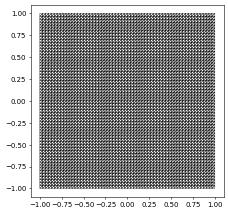

In [2]:
domain2d = (reader.dgf, "triangle.dgf")

# specify dimgrid since it cannot be easily extracted from the dgf file
aluView = leafGridView(domain2d, dimgrid=2)
aluView.plot(figsize=(5,5))


.. index:: Grid construction; gmsh (from file)

There is also a `reader.gmsh` option allowing previously stored `gmsh` files to be
read. The grid is the one used in the [wave equation](wave_nb.ipynb) example.

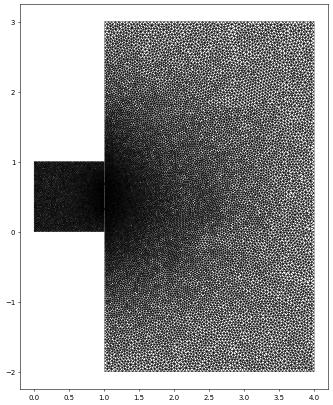

In [3]:
waveDomain = (reader.gmsh, "wave_tank.msh")
waveGrid = leafGridView(waveDomain, dimgrid=2)
waveGrid.plot(figure=pyplot.figure(figsize=(10,10)))


.. index:: Grid construction; pygmsh

## 3D example (using PyGmsh)
In this example we use **pygmsh** to construct a tetrahedral mesh and solve a
simple Laplace problem.
The following code is taken from the **pygmsh** homepage.

In [4]:
try:
    import pygmsh
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon([
              [ 0.0,  0.5, 0.0], [-0.1,  0.1, 0.0], [-0.5,  0.0, 0.0],
              [-0.1, -0.1, 0.0], [ 0.0, -0.5, 0.0], [ 0.1, -0.1, 0.0],
              [ 0.5,  0.0, 0.0], [ 0.1,  0.1, 0.0] ], mesh_size=0.05)
        geom.twist(
            poly,
            translation_axis=[0, 0, 1], rotation_axis=[0, 0, 1], point_on_axis=[0, 0, 0],
            angle=numpy.pi / 3,
        )
        mesh = geom.generate_mesh(verbose=False)

    points, cells = mesh.points, mesh.cells_dict
    domain3d = {"vertices":points.astype("float"), "simplices":cells["tetra"]}
except ImportError: # pygmsh not installed - use a simple cartesian domain
    print("pygmsh module not found using a simple Cartesian domain - ignored")
    from dune.grid import cartesianDomain
    domain3d = cartesianDomain([-0.25,-0.25,0],[0.25,0.25,1],[30,30,60])

gridView3d  = leafGridView(domain3d)
space3d = solutionSpace(gridView3d, order=1)

u = TrialFunction(space3d)
v = TestFunction(space3d)
x = SpatialCoordinate(space3d)
scheme3d = solutionScheme((inner(grad(u),grad(v))+inner(u,v))*dx ==
                        conditional(dot(x,x)<.01,100,0)*v*dx,
                        solver='cg')

uh3d = space3d.interpolate([0],name="solution")
scheme3d.solve(target=uh3d)
# note: plotting with matplotlib not yet available for 3d grids
gridView3d.writeVTK('3dexample', pointdata=[uh3d],
                    outputType=OutputType.appendedraw)

![3d laplace problem](figures/3dexample.png)


.. index:: Grid construction; gmsh2dgf (from Python)

## Converting gmsh to DGF

Using the above convenient way of generating grids
in Python we can then store those as DGF and add boundary
ids for description of more complicated boundaries or
parameters for vertices or cells. Use `gmsh2DGF` from
[gmsh2dgf](gmsh2dgf_nb.ipynb) to convert the above `points` and `cells`


In [5]:
from gmsh2dgf import gmsh2DGF
bndDomain = {1:"-0.6 -0.6 -0.1  0.6 0.6 0.0", # lower bnd gets id 1
             2:"-0.6 -0.6  1.0  0.6 0.6 1.1", # upper bnd gets id 2
             3: "default"} # all other boundary faces get id 3
dgf = gmsh2DGF(points, cells, bndDomain=bndDomain)
with open ("3dmesh.dgf", "w") as file:
    file.write(dgf)


.. index:: Grid construction; meshio

## Using `meshio` to read a gmsh file

We will use the `meshio` package to read a gmsh file, extract the points
and cells and use that to construct a Dune grid. The final part is then
quite similar to the above. We use the 2D grid from the
[wave equation](wave_nb.ipynb) test case. Note that this is a 2D grid but the points are
returned as 3D points so we need to remove the final columns containing
only zeros. We have already seen this grid above so let's zoom in to the
'slit' region...

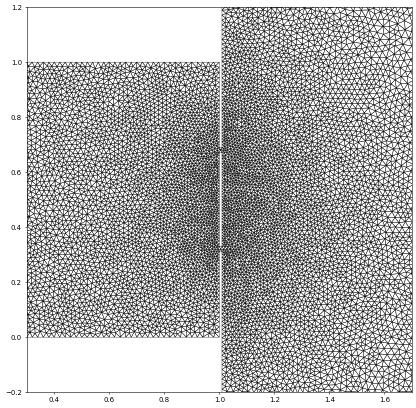

In [6]:
try:
    import numpy as np
    import meshio
    mesh = meshio.read("wave_tank.msh")
    points = np.delete( mesh.points, 2, 1) # remove the z component from the points
    cells = mesh.cells_dict
    waveDomain = {"vertices":points.astype("float"), "simplices":cells["triangle"]}
    waveGrid = leafGridView(waveDomain)
    waveGrid.plot(figure=pyplot.figure(figsize=(10,10)),xlim=[0.3,1.7],ylim=[-0.2,1.2])
except ImportError:
    print("This example requires the meshio package which can be installed using pip.")


.. index:: Grid construction; meshio (quadrilateral grids)

Here is a second example where we want to read a gmsh containing
quadrilateral elements. Note that the vertices of the cells are ordered
counterclockwise which is not identical to the ordering required by the
[Dune reference element](https://www.dune-project.org/doxygen/2.5.0/group__GeometryReferenceElements.html).
The last two vertices need to be exchanged:

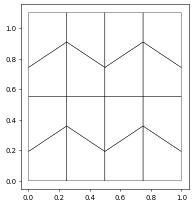

In [7]:
if meshio:
    from dune.alugrid import aluCubeGrid
    mesh = meshio.read("quads.msh")
    points2d = np.delete(mesh.points,2,1)
    cells = mesh.cells_dict['quad']
    cells[:, [2, 3]] = cells[:, [3, 2]]
    domain = {"vertices":points2d, "cubes":cells}
    quadGrid  = aluCubeGrid(domain)
    quadGrid.plot()


## 1D example
It's also possible to create grids in 1D

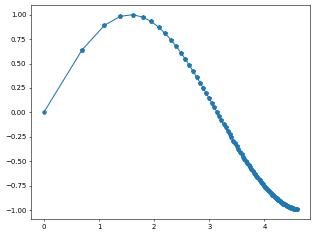

In [8]:
from dune.grid import onedGrid
v = [numpy.log(i) for i in range(1,100)]
e = [(i,i+1) for i in range(1,len(v))]
g = onedGrid(constructor={"vertices":v, "simplices":e})
s = solutionSpace(g)
x = SpatialCoordinate(s)
u = s.interpolate(sin(x[0]), name="u")
u.plot()

pyplot can very easily be used in 1d:
pyplot.plot(g.tessellate()[0], u.pointData(), '-p')